In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
from IPython.display import display
import time
from math import log
t = time.time()

Nous étudions dans ce notebook un modèle **semi-supervisé** utilisant le modèle **Naive Bayes**.

# 1. Chargement de la base Sentiment140 et de la base webscrapée

## 1.1. Base Sentiment140

In [2]:
NB_DATA_140 = 200000
NB_DATA_WEB = 50

In [3]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_140 = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)
df_140.shape

(200000, 6)

In [4]:
df_140.head(10)

,sentiment,id,date,query_string,user,text
0,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
1,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
2,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
3,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
4,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
5,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
6,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
7,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
8,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
9,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


 ## 1.2. Base webscrapée

In [5]:
file = "web"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df_web = pd.read_pickle(os.path.join("data", "web", file + ".bz2"))
df_web.shape

(10588, 7)

In [6]:
df_web.head(10)

,search,author,time,url,text,lang,reply
0,biden,Maggie Klaus 🤶🏻,2019-01-01 22:37:46,/Maggie_Klaus/status/1080231636334067712,shut the f ck up about hillary s likability wh...,en,False
1,biden,The Salt Lake Tribune,2019-01-01 22:15:18,/sltrib/status/1080225983083487232,the agreed to pay former vice president to spe...,en,False
2,biden,The New York Times,2019-01-01 20:00:08,/nytimes/status/1080191967873716224,a series of careful financial decisions and th...,en,False
3,biden,Matt Binder,2019-01-01 22:18:51,/MattBinder/status/1080226876226965504,i agree this is useful democrats should defini...,en,False
4,biden,Patrick Healy,2019-01-01 19:58:58,/patrickhealynyt/status/1080191673701933059,news joe biden s campaign in waiting includes ...,en,False
5,biden,Ashton Pittman,2019-01-01 23:52:34,/ashtonpittman/status/1080250459200344065,also on fox news newt gingrich praised sen mar...,en,False
6,biden,Ashton Pittman,2019-01-01 23:52:35,/ashtonpittman/status/1080250465718288384,republicans at fox news even had high praise f...,en,False
7,biden,Virgil Xmas 🎄🎁💸,2019-01-01 22:25:54,/virgiltexas/status/1080228651327733760,for every joe biden he votes for i am going to...,en,False
8,biden,Katelyn Burns,2019-01-01 22:01:53,/transscribe/status/1080222604668166144,the unspoken and untrue premise of this piece ...,en,False
9,biden,Susan Murphy,2019-01-01 22:59:08,/susmurphy/status/1080237012689530883,re the dem race i will vote for whoever is the...,en,False


## 1.3. Catégorisation à la main

In [7]:
df_web_cat = pd.read_pickle(os.path.join("data", "web", file + ".bz2")).sample(NB_DATA_WEB, random_state=1234).reset_index(drop=True)
df_web_cat.shape

(50, 7)

In [8]:
df_web_cat.head(10)

,search,author,time,url,text,lang,reply
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False


In [9]:
from google_trans_new import google_translator  
  
translator = google_translator()  
translate_text = translator.translate("Hello my name is Bob", lang_tgt='fr')  
print(translate_text)

Bonjour, mon nom est Bob 


In [10]:
# %%time
# temp = df_web_cat.copy()
# temp['text_trad'] = temp.text.map(lambda x: translator.translate(x, lang_tgt='fr'))
# temp.head(10)

In [11]:
# temp['sentiment'] = 0

In [12]:
# temp.to_excel(os.path.join("data", "web", "cat.xlsx"))

In [13]:
df_temp = pd.read_excel(os.path.join("data", "web", "cat_.xlsx")).drop(columns=['Unnamed: 0', 'text_trad'])
df_temp.sentiment = df_temp.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df_temp.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


In [14]:
(df_web_cat.text == df_temp.text).all()

True

In [15]:
df_web_cat['sentiment'] = df_temp.sentiment
df_web_cat.head(10)

,search,author,time,url,text,lang,reply,sentiment
0,trump,Tea Pain,2019-12-27 23:48:11,/TeaPainUSA/status/1210708987143954437,weak and whiney,en,False,Negative
1,trump,Lincoln17 😊✌🌊❤🗽🌏🌈🎶,2019-09-30 23:58:44,/Lincoln1710/status/1178821513249775616,reality winner a whistleblower alerted the med...,en,False,Negative
2,biden,Eric Darcman,2019-09-08 23:06:58,/Darcman/status/1170835953067466753,poc will decide who the nominee is in the plac...,en,False,Negative
3,biden,"Joe Pizza's Accountant, Shlomi Matzoball 🔥",2019-12-27 22:57:05,/rev_avocado/status/1210696130440224768,but you know i am sure the hundredth joke abou...,en,False,Negative
4,trump,Make Integrity Great Again [Drapeau des États-...,2019-05-20 23:58:57,/CinnamonHH/status/1130623980434546690,i have had heat exhaustion and it is awful why...,en,False,Negative
5,trump,James S,2019-08-16 23:55:49,/JAlford1493/status/1162513323604111360,they just know how the movie ends they ed stil...,en,False,Negative
6,trump,#CountEveryVote Debrianna📢,2019-10-07 23:59:54,/DMansini/status/1181358518923743233,has it become completely obvious yet that this...,en,False,Negative
7,biden,doncalloway,2019-10-22 23:30:54,/dcstl/status/1186787039838003201,there is a very good chance that joe biden wil...,en,False,Positive
8,biden,ᎠᏌNᎬᎷYᎢᎻᎪNᏩ™️,2019-02-10 23:25:56,/Kris_Sacrebleu/status/1094739271703965696,i see a few candidates making some missteps ou...,en,False,Positive
9,trump,Charles Nutter,2019-01-08 23:56:39,/headius/status/1082788202853875712,this is the anger and hate politics you suppor...,en,False,Negative


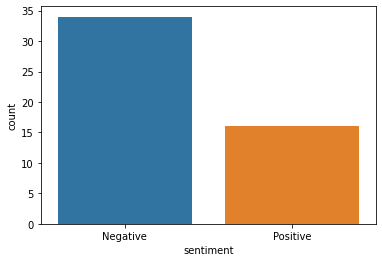

In [16]:
sns.countplot(x='sentiment', data=df_web_cat)
plt.show()

In [17]:
X_140 = df_140.text.to_list()
y_140 = df_140.sentiment.to_list()
y_140_bool = (np.array(y_140) == 'Positive').astype(int).tolist()

X_web = df_web.text.to_list()
X_web_cat = df_web_cat.text.to_list()
y_web_cat = df_web_cat.sentiment.to_list()
y_web_cat_bool = (np.array(y_web_cat) == 'Positive').astype(int).tolist()

# 2. Performances des modèles précédents

On fait attention à bien fitter le vectorizer sur les bases Sentiment140 et webscrapée 

In [18]:
def conf_matrix(X_supervised, y_supervised, X_unsup, X_unsup_cat, y_unsup_cat, vectorizer, scaling, model, graph=True, verbose=True):
    vectorizer.fit(X_supervised+X_unsup)
    X_supervised = vectorizer.transform(X_supervised)
    
    if scaling:
        scaler = StandardScaler(with_mean=False)
        X_supervised = scaler.fit_transform(X_supervised)

    X_train_supervised, X_test_supervised, y_train_supervised, y_test_supervised = train_test_split(X_supervised, y_supervised, train_size=0.80, random_state=1234)
    
    model.fit(X_train_supervised, y_train_supervised)    
    y_pred_supervised = model.predict(X_test_supervised)
    
    X_unsup_cat = vectorizer.transform(X_unsup_cat)
    if scaling:
        X_unsup_cat = scaler.transform(X_unsup_cat)

    y_pred_unsup_cat = model.predict(X_unsup_cat)
    
    for (X_test, y_test, y_pred) in [(X_test_supervised, y_test_supervised, y_pred_supervised), (X_unsup_cat, y_unsup_cat, y_pred_unsup_cat)]:

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
        sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
        sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        if graph:
            metrics.plot_confusion_matrix(model, X_test, y_test)
            plt.show()
        
        if verbose:
            print(f"Accuracy : {sc_accuracy:.4f}")
            print(f"Balanced accuracy : {sc_balanced_accuracy:.4f}")
        #     print(f"Recall : {sc_recall}")
        #     print(f"Precision : {sc_precision}")
        #     print(f"F1 : {sc_f1}")
            print(f"ROC AUC : {sc_roc_auc:.4f}")

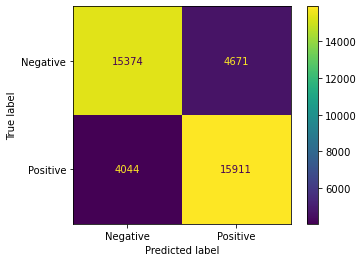

Accuracy : 0.7821
Balanced accuracy : 0.7824
ROC AUC : 0.8524


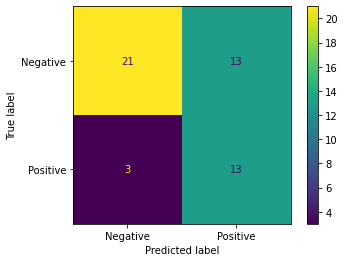

Accuracy : 0.6800
Balanced accuracy : 0.6875
ROC AUC : 0.7868
Wall time: 6.95 s


In [19]:
%%time
_ = conf_matrix(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000), True, LogisticRegression())

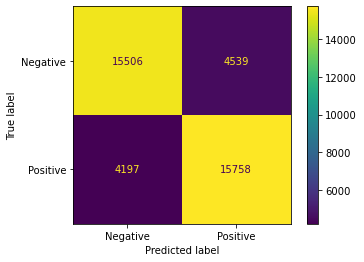

Accuracy : 0.7816
Balanced accuracy : 0.7817
ROC AUC : 0.8615


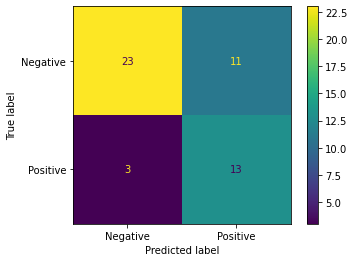

Accuracy : 0.7200
Balanced accuracy : 0.7131
ROC AUC : 0.8070
Wall time: 6.38 s


In [20]:
%%time
_ = conf_matrix(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), True, LogisticRegression())

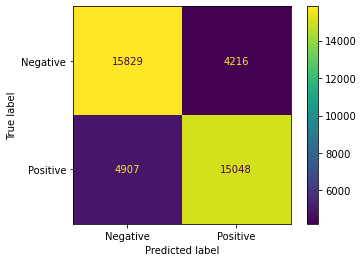

Accuracy : 0.7719
Balanced accuracy : 0.7723
ROC AUC : 0.8442


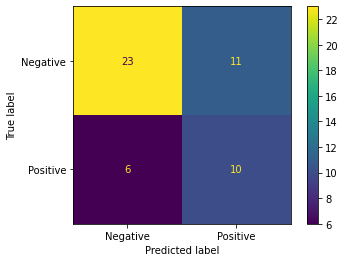

Accuracy : 0.6600
Balanced accuracy : 0.6346
ROC AUC : 0.6801
Wall time: 5.52 s


In [21]:
%%time
_ = conf_matrix(X_140, y_140, X_web, X_web_cat, y_web_cat, CountVectorizer(max_features=6000), False, MultinomialNB(alpha=1))

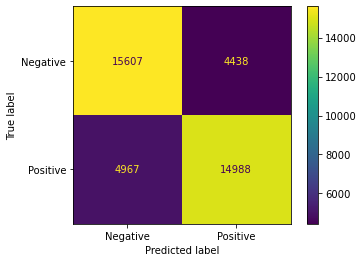

Accuracy : 0.7649
Balanced accuracy : 0.7651
ROC AUC : 0.8477


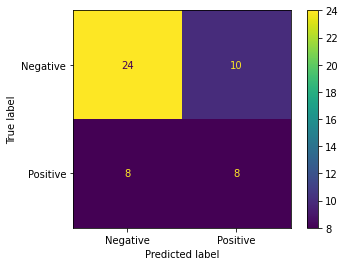

Accuracy : 0.6400
Balanced accuracy : 0.5972
ROC AUC : 0.6434
Wall time: 5.63 s


In [22]:
%%time
_ = conf_matrix(X_140, y_140, X_web, X_web_cat, y_web_cat, TfidfVectorizer(max_features=6000), False, MultinomialNB(alpha=1))

# 3. Apprentissage semi-supervisé

Nous utilisons une modification du modèle MuntinomialNB disponible sur ce projet : https://github.com/jmatayoshi/semi-supervised-naive-bayes

In [23]:
from semi_supervised_naive_bayes import MultinomialNBSS

In [24]:
def conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, vectorizer, facteur=None, beta=1, verbose=True):
    if facteur or facteur==0:
        correction = int((len(X_140)/(len(X_web))) * facteur)
        X_web_new = X_web * correction
    else:
        X_web_new = X_web

    print(f"Nombre de lignes base Sentiment140 : {len(X_140)}")
    print(f"Nombre de lignes base Webscrapée   : {len(X_web_new)}")

    model = MultinomialNBSS(alpha=1, beta=beta)

    X_train_140, X_test_140, y_train_140, y_test_140 = train_test_split(X_140, y_140_bool, train_size=0.80, random_state=1234)

    X_train_all = X_train_140 + X_web_new
    y_train_all = y_train_140 + [-1]*len(X_web_new)
    X_train_all = vectorizer.fit_transform(X_train_all)

    model.fit(X_train_all, y_train_all)

    X_test_140_vec = vectorizer.transform(X_test_140)    
    y_pred_140 = model.predict(X_test_140_vec)

    X_web_cat_vec = vectorizer.transform(X_web_cat)
    y_pred_web_cat = model.predict(X_web_cat_vec)

    for (X_test, y_test, y_pred) in [(X_test_140_vec, y_test_140, y_pred_140), (X_web_cat_vec, y_web_cat_bool, y_pred_web_cat)]:
        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        if verbose:
            metrics.plot_confusion_matrix(model, X_test, y_test)
            plt.show()
            print(f"Accuracy : {sc_accuracy:.4f}")
            print(f"Balanced accuracy : {sc_balanced_accuracy:.4f}")
            print(f"ROC AUC : {sc_roc_auc:.4f}")        

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 0


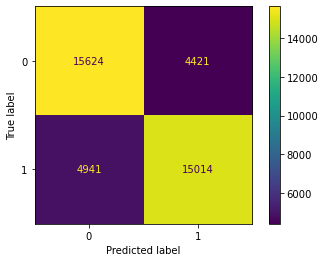

Accuracy : 0.7660
Balanced accuracy : 0.7661
ROC AUC : 0.8479


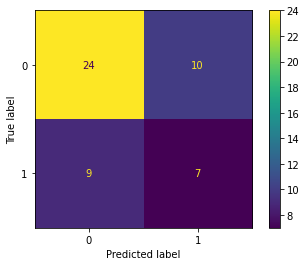

Accuracy : 0.6200
Balanced accuracy : 0.5695
ROC AUC : 0.5680


In [25]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=0)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 10588
Step 1: jll = -7634397.849317
Step 2: jll = -7634503.899645
Step 3: jll = -7634843.227177
Step 4: jll = -7635326.052958
Step 5: jll = -7635919.331111
Step 6: jll = -7636583.516446
Step 7: jll = -7637276.657964
Step 8: jll = -7637956.840926
Step 9: jll = -7638585.246085
Step 10: jll = -7639133.575778
Step 11: jll = -7639588.554851
Step 12: jll = -7639950.667743
Step 13: jll = -7640229.523256
Step 14: jll = -7640438.914787
Step 15: jll = -7640593.211558
Step 16: jll = -7640705.348771
Step 17: jll = -7640786.033427
Step 18: jll = -7640843.671136
Step 19: jll = -7640884.634168
Step 20: jll = -7640913.640518
Optimization converged after 20 iterations.


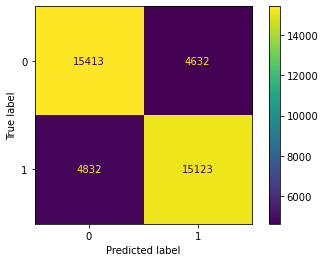

Accuracy : 0.7634
Balanced accuracy : 0.7634
ROC AUC : 0.8445


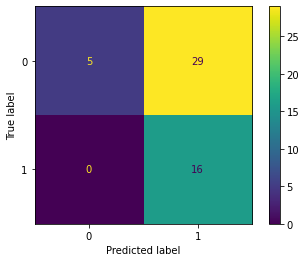

Accuracy : 0.4200
Balanced accuracy : 0.6778
ROC AUC : 0.5699


In [26]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=None)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 190584
Step 1: jll = -19188368.247966
Step 2: jll = -19186878.972434
Optimization converged after 2 iterations.


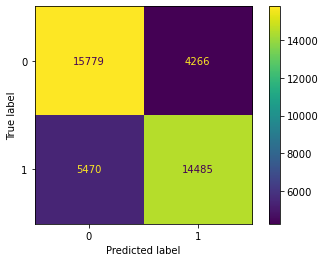

Accuracy : 0.7566
Balanced accuracy : 0.7575
ROC AUC : 0.8377


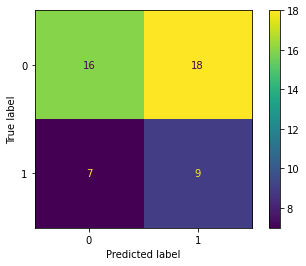

Accuracy : 0.5000
Balanced accuracy : 0.5145
ROC AUC : 0.5680


In [27]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), facteur=1)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 10588
Step 1: jll = -7634397.849317
Step 2: jll = -7634503.899645
Step 3: jll = -7634843.227177
Step 4: jll = -7635326.052958
Step 5: jll = -7635919.331111
Step 6: jll = -7636583.516446
Step 7: jll = -7637276.657964
Step 8: jll = -7637956.840926
Step 9: jll = -7638585.246085
Step 10: jll = -7639133.575778
Step 11: jll = -7639588.554851
Step 12: jll = -7639950.667743
Step 13: jll = -7640229.523256
Step 14: jll = -7640438.914787
Step 15: jll = -7640593.211558
Step 16: jll = -7640705.348771
Step 17: jll = -7640786.033427
Step 18: jll = -7640843.671136
Step 19: jll = -7640884.634168
Step 20: jll = -7640913.640518
Optimization converged after 20 iterations.


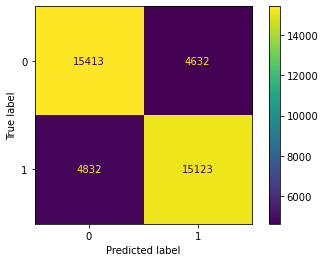

Accuracy : 0.7634
Balanced accuracy : 0.7634
ROC AUC : 0.8445


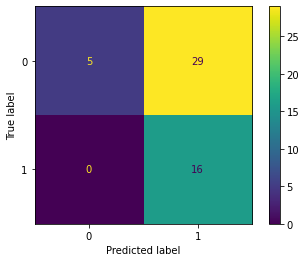

Accuracy : 0.4200
Balanced accuracy : 0.6778
ROC AUC : 0.5699


In [28]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=1)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 10588
Step 1: jll = -7639046.518186
Step 2: jll = -7639012.619546
Optimization converged after 2 iterations.


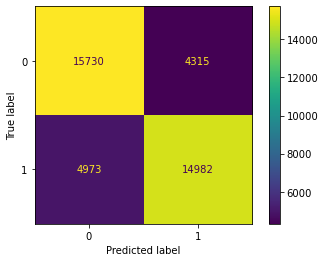

Accuracy : 0.7678
Balanced accuracy : 0.7681
ROC AUC : 0.8489


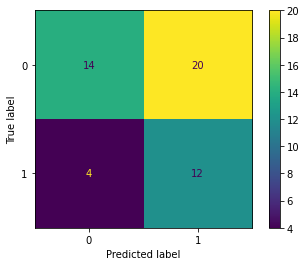

Accuracy : 0.5200
Balanced accuracy : 0.5764
ROC AUC : 0.5993


In [29]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=2)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 10588
Step 1: jll = -7678155.168704
Step 2: jll = -7677697.874858
Optimization converged after 2 iterations.


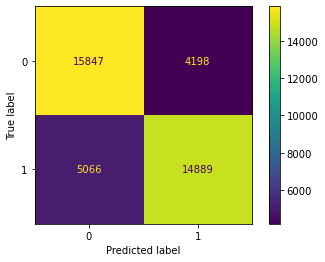

Accuracy : 0.7684
Balanced accuracy : 0.7689
ROC AUC : 0.8498


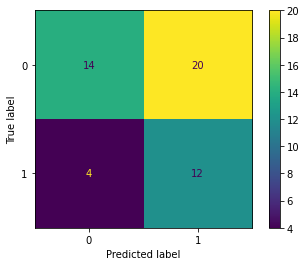

Accuracy : 0.5200
Balanced accuracy : 0.5764
ROC AUC : 0.5956


In [30]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=5)

Nombre de lignes base Sentiment140 : 200000
Nombre de lignes base Webscrapée   : 10588
Step 1: jll = -7635271.925963
Step 2: jll = -7635310.989500
Step 3: jll = -7635660.603523
Step 4: jll = -7636192.833512
Step 5: jll = -7636889.313958
Step 6: jll = -7637720.808522
Step 7: jll = -7638642.142900
Step 8: jll = -7639591.402017
Step 9: jll = -7640497.703735
Step 10: jll = -7641301.210302
Step 11: jll = -7641968.323643
Step 12: jll = -7642493.078478
Step 13: jll = -7642888.862269
Step 14: jll = -7643178.142283
Step 15: jll = -7643384.814498
Step 16: jll = -7643530.097359
Step 17: jll = -7643631.074593
Step 18: jll = -7643700.708355
Step 19: jll = -7643748.468621
Step 20: jll = -7643781.105117
Optimization converged after 20 iterations.


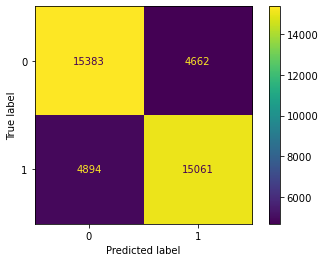

Accuracy : 0.7611
Balanced accuracy : 0.7611
ROC AUC : 0.8421


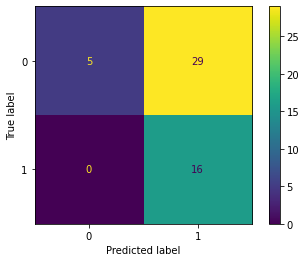

Accuracy : 0.4200
Balanced accuracy : 0.6778
ROC AUC : 0.5551


In [31]:
conf_matrix_semi(X_140, y_140_bool, X_web, X_web_cat, y_web_cat_bool, TfidfVectorizer(max_features=6000), beta=1.5)